# Keyword-based News Classification using Frequent Words


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split

# Load the Kaggle dataset (ensure it is downloaded locally first)
# File name typically: 'News_Category_Dataset_v3.json'

news_df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

# Select only the categories of interest
chosen_classes = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
news_df = news_df[news_df['category'].isin(chosen_classes)]

# Extract only necessary fields
news_df = news_df[["short_description", "category"]]

# Sample equally (1,000 records from each class)
sampled_df = (
    news_df.groupby("category")
    .apply(lambda subset: subset.sample(1000, random_state=42))
    .reset_index(drop=True)
)

# Divide into training and testing partitions (stratified by category)
train_data, test_data = train_test_split(
    sampled_df,
    test_size=0.2,
    stratify=sampled_df['category'],
    random_state=42
)

print(train_data.shape, test_data.shape)


(3200, 2) (800, 2)


C:\Users\bbuser\AppData\Local\Temp\ipykernel_26484\3140332267.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda subset: subset.sample(1000, random_state=42))


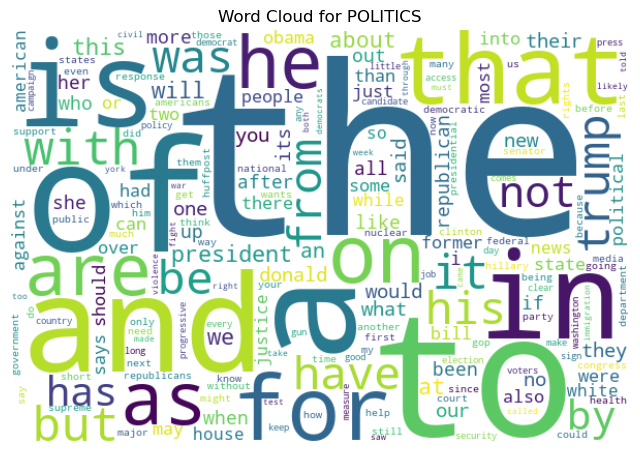

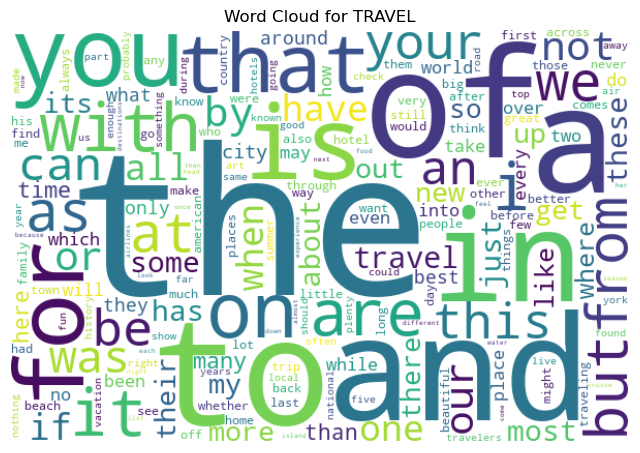

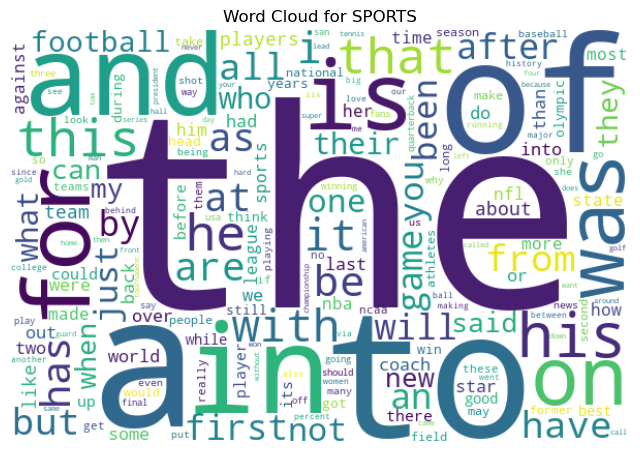

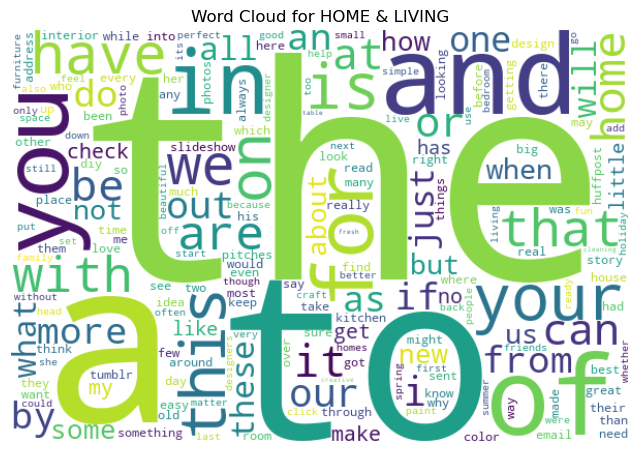

In [2]:
category_token_stats = {}

for label in chosen_classes:
    combined_text = " ".join(train_data[train_data['category'] == label]['short_description'].str.lower())
    tokens = [tok for tok in combined_text.split() if tok.isalpha()]
    freq_counts = Counter(tokens)
    category_token_stats[label] = freq_counts

    # Generate and display word cloud
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(freq_counts)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {label}")
    plt.show()

# Function to retrieve top-N frequent terms
def extract_top_terms(freq_counts, n_terms):
    return [term for term, _ in freq_counts.most_common(n_terms)]


In [3]:
def predict_category(sentence, keyword_map):
    tokens = {tok for tok in sentence.lower().split() if tok.isalpha()}
    match_scores = {cls: len(tokens & set(top_terms)) for cls, top_terms in keyword_map.items()}

    highest = max(match_scores.values())
    if highest == 0 or list(match_scores.values()).count(highest) > 1:
        return "UNKNOWN"
    return max(match_scores, key=match_scores.get)


In [4]:
evaluation_results = []

for top_n in [10, 20, 30, 50]:
    keyword_map = {cls: extract_top_terms(category_token_stats[cls], top_n) for cls in chosen_classes}

    predictions = test_data['short_description'].apply(lambda txt: predict_category(txt, keyword_map))

    valid_mask = predictions != "UNKNOWN"
    accuracy = (predictions[valid_mask] == test_data[valid_mask]['category']).mean()

    evaluation_results.append((top_n, accuracy, (predictions == "UNKNOWN").mean()))

    print(f"Top {top_n} terms → Accuracy: {accuracy:.3f}, Unknown rate: {(predictions=='UNKNOWN').mean():.2f}")


Top 10 terms → Accuracy: 0.427, Unknown rate: 0.84
Top 20 terms → Accuracy: 0.492, Unknown rate: 0.70
Top 30 terms → Accuracy: 0.504, Unknown rate: 0.70
Top 50 terms → Accuracy: 0.603, Unknown rate: 0.69


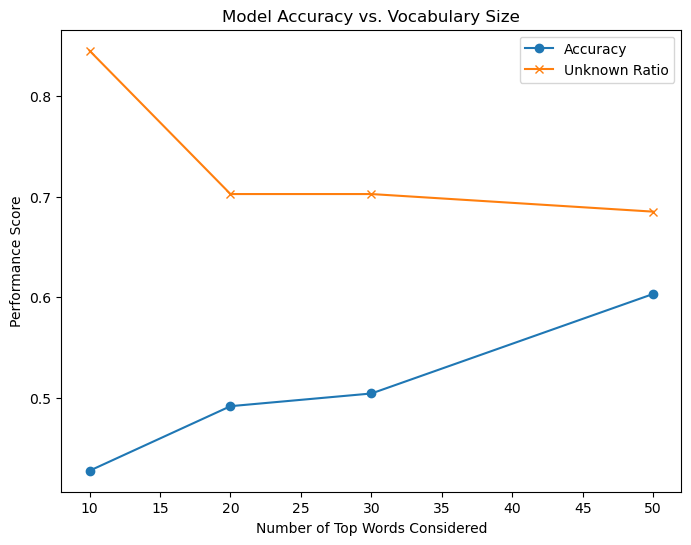

,top_terms,accuracy,unknown_ratio
0,10,0.427419,0.8450
1,20,0.491597,0.7025
2,30,0.504202,0.7025
3,50,0.603175,0.6850


In [5]:
results_table = pd.DataFrame(evaluation_results, columns=["top_terms", "accuracy", "unknown_ratio"])

plt.figure(figsize=(8, 6))
plt.plot(results_table['top_terms'], results_table['accuracy'], marker='o', label="Accuracy")
plt.plot(results_table['top_terms'], results_table['unknown_ratio'], marker='x', label="Unknown Ratio")
plt.xlabel("Number of Top Words Considered")
plt.ylabel("Performance Score")
plt.title("Model Accuracy vs. Vocabulary Size")
plt.legend()
plt.show()

results_table
